In [438]:
import pandas as pd
import numpy as np
import ast
import itertools

import seaborn as sns
import matplotlib.pyplot as plt


### Loading Data

In [2]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [3]:
fix_A_path = "full/fixations_A.csv"
df_fix_A = pd.read_csv(fix_A_path)

C:\Users\deeth\AppData\Local\Temp\ipykernel_29044\878136727.py:2: DtypeWarning: Columns (37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fix_A = pd.read_csv(fix_A_path)


### Data Preprocessing

In [4]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'
q_ind = 'same_critical_span'

df_A_filtered['text_id'] = (
    df_A_filtered[article_col].astype(str) + '_' +
    df_A_filtered[difficulty_col].astype(str) + '_' +
    df_A_filtered[batch_col].astype(str) + '_' +
    df_A_filtered[paragraph_col].astype(str) + '_' +
    df_A_filtered[q_ind].astype(str)
    )

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True].copy()
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False].copy()

C:\Users\deeth\AppData\Local\Temp\ipykernel_29044\1610736497.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A_filtered['text_id'] = (


In [5]:
df_fix_filtered = df_fix_A[(df_fix_A['repeated_reading_trial'] == False) & ((df_fix_A['practice_trial'] == False))]

df_fix_hunters = df_fix_filtered[df_fix_filtered['question_preview'] == True].copy()
df_fix_gatherers = df_fix_filtered[df_fix_filtered['question_preview'] == False].copy()

In [6]:
def get_fix_columns(df):
    df_fix = (
        df
        .groupby(['participant_id', 'TRIAL_INDEX'], sort=False)
        .agg({
            'CURRENT_FIX_INTEREST_AREA_INDEX': lambda x: tuple(x),
            'CURRENT_FIX_DURATION':             lambda x: tuple(x),
            'CURRENT_FIX_X':                    lambda x: tuple(x),
            'CURRENT_FIX_Y':                    lambda x: tuple(x),
        })
        .reset_index()
        .rename(columns={
            'CURRENT_FIX_INTEREST_AREA_INDEX': 'fix_seq',
            'CURRENT_FIX_DURATION':            'fix_duration',
            'CURRENT_FIX_X':                   'fix_x',
            'CURRENT_FIX_Y':                   'fix_y',
        })
    )

    #collapse consecutive duplicates: sum durations, avg coords
    def collapse_runs(seq, durations, xs, ys):
        short_seq = []
        short_durs = []
        avg_xs = []
        avg_ys = []

        for fixation, group in itertools.groupby(
            zip(seq, durations, xs, ys),
            key=lambda t: t[0]
        ):
            run = list(group)
            total_dur = sum(item[1] for item in run)
            mean_x = sum(item[2] for item in run) / len(run)
            mean_y = sum(item[3] for item in run) / len(run)

            short_seq.append(fixation)
            short_durs.append(total_dur)
            avg_xs.append(mean_x)
            avg_ys.append(mean_y)

        return (
            tuple(short_seq),
            tuple(short_durs),
            tuple(avg_xs),
            tuple(avg_ys),
        )

    df_fix[['short_fix_seq',
            'short_fix_duration',
            'short_fix_x',
            'short_fix_y']] = (
        df_fix
        .apply(lambda row: pd.Series(
            collapse_runs(
                row['fix_seq'],
                row['fix_duration'],
                row['fix_x'],
                row['fix_y'],
            )
        ), axis=1)
    )

    return df_fix

In [7]:
df_h_fix = get_fix_columns(df_fix_hunters)
df_g_fix = get_fix_columns(df_fix_gatherers)

In [8]:
df_A_hunters = df_A_hunters.merge(df_h_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')
df_A_gatherers = df_A_gatherers.merge(df_g_fix, on=['TRIAL_INDEX', 'participant_id'], how='left')

### Creating Features

In [166]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [167]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [168]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [169]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_area_screen_loc,
    create_area_label,
    create_selected_answer_label
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_area_screen_loc at 0x000001D610EE9670>
<function create_area_label at 0x000001D33138A280>
<function create_selected_answer_label at 0x000001D627BCC3A0>
<function create_area_screen_loc at 0x000001D610EE9670>
<function create_area_label at 0x000001D33138A280>
<function create_selected_answer_label at 0x000001D627BCC3A0>


In [405]:
df_base_features_h = df_base_features_h[df_base_features_h['area_label'] != 'question']
df_base_features_h = df_base_features_h[df_base_features_h['area_screen_loc'] != 'question']

df_base_features_g = df_base_features_g[df_base_features_g['area_label'] != 'question']
df_base_features_g = df_base_features_g[df_base_features_g['area_screen_loc'] != 'question']

In [ ]:
# def remove_questions(df,
#                      source_col='first_visits_area_label',
#                      target_col='first_vis_no_q'):
#     df[target_col] = df[source_col].apply(
#         lambda lst: tuple(item for item in lst if item != 'question')
#     )
#     return df



In [406]:
def create_fixation_sequence_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        label_sequence = []
        location_sequence = []

        for ia_id in sequence:
            if ia_id in group_ids:
                label_sequence.append(id_to_label[ia_id])
                location_sequence.append(id_to_location[ia_id])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': tuple(label_sequence[1:]),
            'fix_by_loc': tuple(location_sequence[1:])
        })

    return pd.DataFrame(result)

In [407]:
def create_simplified_fixation_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        durations = group['short_fix_duration'].iloc[0]
        xs        = group['short_fix_x'].iat[0]
        ys        = group['short_fix_y'].iat[0]

        valid_fixations = []
        for ia_id, dur, x, y in zip(sequence, durations, xs, ys):
            if ia_id in group_ids:
                valid_fixations.append((
                    ia_id,
                    id_to_label[ia_id],
                    id_to_location[ia_id],
                    dur,
                    x,
                    y
                ))

        simpl_labels    = []
        simpl_locations = []
        simpl_durations = []
        simpl_xs        = []
        simpl_ys        = []

        for label, run in itertools.groupby(valid_fixations, key=lambda item: item[1]):
            run_list = list(run)
            simpl_labels.append(label)
            simpl_locations.append(run_list[0][2])
            simpl_durations.append(sum(item[3] for item in run_list)/len(run_list))
            simpl_xs.append(sum(item[4] for item in run_list) / len(run_list))
            simpl_ys.append(sum(item[5] for item in run_list) / len(run_list))

        result.append({
            'TRIAL_INDEX':       trial_index,
            'participant_id':    participant_id,
            'simpl_fix_by_label':    tuple(simpl_labels[1:]),
            'simpl_fix_by_loc':      tuple(simpl_locations[1:]),
            'simpl_fix_duration':    tuple(simpl_durations[1:]),
            'simpl_fix_x':           tuple(simpl_xs[1:]),
            'simpl_fix_y':           tuple(simpl_ys[1:])
        })
    return pd.DataFrame(result)

In [408]:
def first_visits_ordered(df):
    df = df.copy()

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        seen = set()
        label_seq = []
        loc_seq = []
        for labels, screen_locs in zip(group['fix_by_label'], group['fix_by_loc']):
            for label, screen_loc in zip(labels, screen_locs):
                if (label, screen_loc) not in seen:
                    seen.add((label, screen_loc))
                    label_seq.append(label)
                    loc_seq.append(screen_loc)
        label_seq = tuple(label_seq)
        loc_seq = tuple(loc_seq)
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'first_visits_area_label': label_seq,
            'first_visits_area_screen_loc': loc_seq
        })
    df_first_visits = pd.DataFrame(result)
    return df_first_visits

In [409]:
def last_visits_ordered(df):
    df = df.copy()

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        seen = set()
        label_seq = []
        loc_seq = []
        for labels, screen_locs in zip(group.iloc[::-1]['fix_by_label'], group.iloc[::-1]['fix_by_loc']):
            i = 0
            for label, screen_loc in zip(reversed(labels), reversed(screen_locs)):
                i = i +1
                if (label, screen_loc) not in seen:
                    seen.add((label, screen_loc))
                    label_seq.append(label)
                    loc_seq.append(screen_loc)
        label_seq = tuple(label_seq[::-1])
        loc_seq = tuple(loc_seq[::-1])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'last_visits_area_label': label_seq,
            'last_visits_area_screen_loc': loc_seq
        })
    df_first_visits = pd.DataFrame(result)
    return df_first_visits

In [410]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(result_df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [411]:
per_row_feature_generators = [
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_simplified_fixation_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (first_visits_ordered, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (last_visits_ordered, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
]

In [412]:
df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_fixation_sequence_tags at 0x000001D77D1803A0>
<function create_simplified_fixation_tags at 0x000001D77D199EE0>
<function first_visits_ordered at 0x000001D77D1808B0>
<function last_visits_ordered at 0x000001D77D180790>
<function create_fixation_sequence_tags at 0x000001D77D1803A0>
<function create_simplified_fixation_tags at 0x000001D77D199EE0>
<function first_visits_ordered at 0x000001D77D1808B0>
<function last_visits_ordered at 0x000001D77D180790>


### Mixing the Sequences


In [413]:
def mix_fix_dummy(df,
                  loc_col='simpl_fix_by_loc',
                  label_col='simpl_fix_by_label',
                  result_col='simpl_fix_mixed',
                  n_loc=4):
    df = df.copy()
    df[result_col] = df.apply(
        lambda r: tuple(r[loc_col])[:n_loc] + tuple(r[label_col])[n_loc:],
        axis=1)
    return df


In [414]:
def trim_simpl_sequences(df, source, results):
    def trim(seq):
        if len(seq) <= 5:
            return seq
        else:
            return seq[4:-1]

    for src_col, res_col in zip(source, results):
        df[res_col] = df[src_col].apply(trim)
    return df


In [419]:
def label_rhombus_transitions(df, source = '', result = 'loc_clock'):
    cw = {('answer_0','answer_2'),
          ('answer_2','answer_3'),
          ('answer_3','answer_1'),
          ('answer_1','answer_0')}

    ccw = {('answer_0','answer_1'),
           ('answer_1','answer_3'),
           ('answer_3','answer_2'),
           ('answer_2','answer_0')}

    across = {('answer_0','answer_3'),
              ('answer_3','answer_0'),
              ('answer_1','answer_2'),
              ('answer_2','answer_1')}

    def label(seq):
        if len(seq) < 2:
            return ()
        labels = []
        for a, b in zip(seq[:len(seq) - 1], seq[1:]):

            pair = (a, b)
            if pair in cw:
                labels.append('clckw')
            elif pair in ccw:
                labels.append('counter_clckw')
            elif pair in across:
                labels.append('across')
            else:
                labels.append('unknown')
        return tuple(labels)

    df[result] = df[source].apply(label)
    return df

In [420]:
df_with_features_h = mix_fix_dummy(df_with_features_h,loc_col='simpl_fix_by_loc',label_col='simpl_fix_by_label',
                                   result_col='simpl_fix_mixed',n_loc=4)
df_with_features_g = mix_fix_dummy(df_with_features_g,loc_col='simpl_fix_by_loc',label_col='simpl_fix_by_label',
                                   result_col='simpl_fix_mixed',n_loc=4)

df_with_features_h = mix_fix_dummy(df_with_features_h,loc_col='fix_by_loc',label_col='fix_by_label',result_col='fix_mixed', n_loc=4)
df_with_features_g = mix_fix_dummy(df_with_features_g,loc_col='fix_by_loc',label_col='fix_by_label',result_col='fix_mixed', n_loc=4)

In [421]:
df_with_features_h = trim_simpl_sequences(df_with_features_h,
    source = ['simpl_fix_by_loc', 'simpl_fix_by_label', 'simpl_fix_duration', 'simpl_fix_x', 'simpl_fix_y'],
    results = ['trimmed_simpl_fix_by_loc', 'trimmed_simpl_fix_by_label',
               'trimmed_simpl_fix_duration', 'trimmed_simpl_fix_x', 'trimmed_simpl_fix_y'])

df_with_features_g = trim_simpl_sequences(df_with_features_g,
    source = ['simpl_fix_by_loc', 'simpl_fix_by_label', 'simpl_fix_duration', 'simpl_fix_x', 'simpl_fix_y'],
    results = ['trimmed_simpl_fix_by_loc', 'trimmed_simpl_fix_by_label',
               'trimmed_simpl_fix_duration', 'trimmed_simpl_fix_x', 'trimmed_simpl_fix_y'])


In [422]:
df_with_features_h = label_rhombus_transitions(df_with_features_h, 'simpl_fix_by_loc', 'clock_loc')
df_with_features_g = label_rhombus_transitions(df_with_features_g, 'simpl_fix_by_loc', 'clock_loc')

### Starts/Ends Frequencies Graphs


#### General Population

In [442]:
def plot_freq_hist(df, column='first_vis_by_loc', top_n=None, figsize=(15,6), h_or_g = 'undefined', ans = '?', ttl = None,
                   save = True):
    counts = df[column].value_counts(dropna=False)

    if top_n is not None:
        counts = counts.head(top_n)

    plt.figure(figsize=figsize)
    counts.plot(kind='bar')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Frequency')
    if not ttl:
        ttl = f'hist_{column}_top-{top_n}_{h_or_g}_answered_{ans}'
        plt.title(ttl)
    else:
        plt.title(ttl)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        plt.savefig("plots/visits_hists/" + ttl + ".png")
    plt.show()

In [ ]:
for l in ['A', 'B', 'C', 'D']:
    data = df_with_features_h[df_with_features_h['selected_answer_label'] == l]
    for col in ['first_visits_area_label', 'first_visits_area_screen_loc', 'last_visits_area_label', 'last_visits_area_screen_loc']:
        df = data[['TRIAL_INDEX', 'participant_id', col]].drop_duplicates()
        plot_freq_hist(df, column=col, top_n=35, h_or_g = 'hunters', ans = l)

#### Participant Splits

Participant l42_488


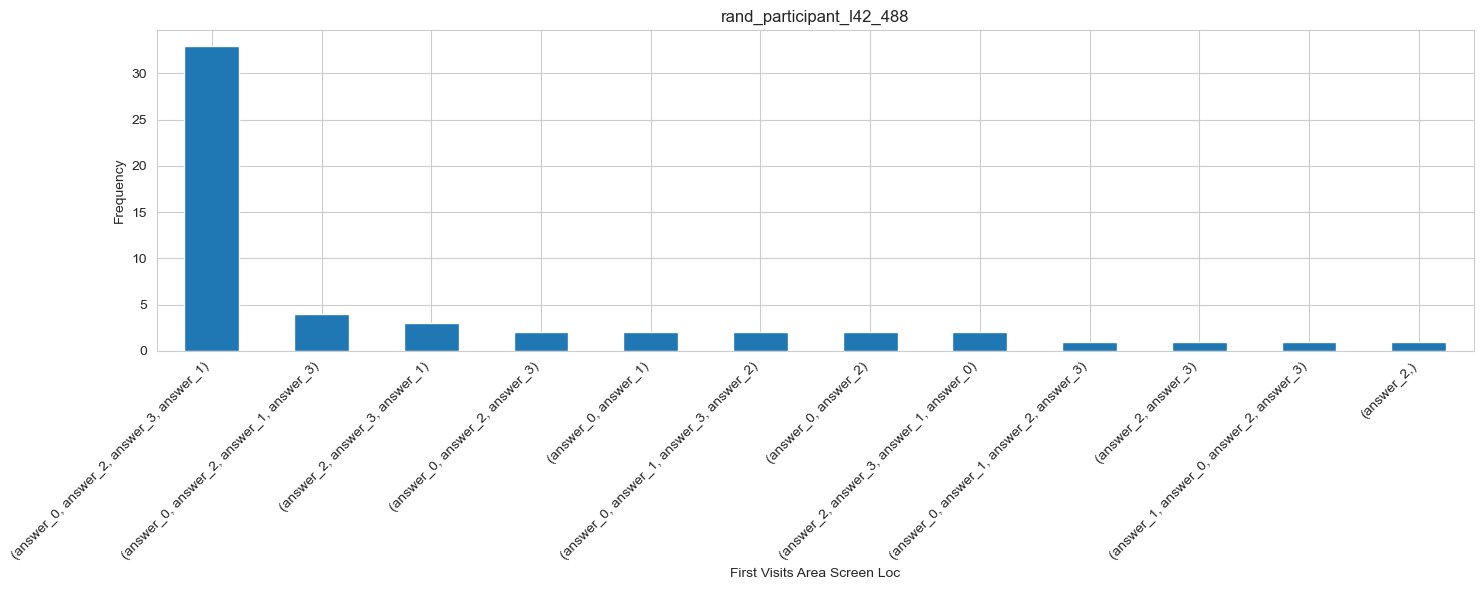

Participant l13_42


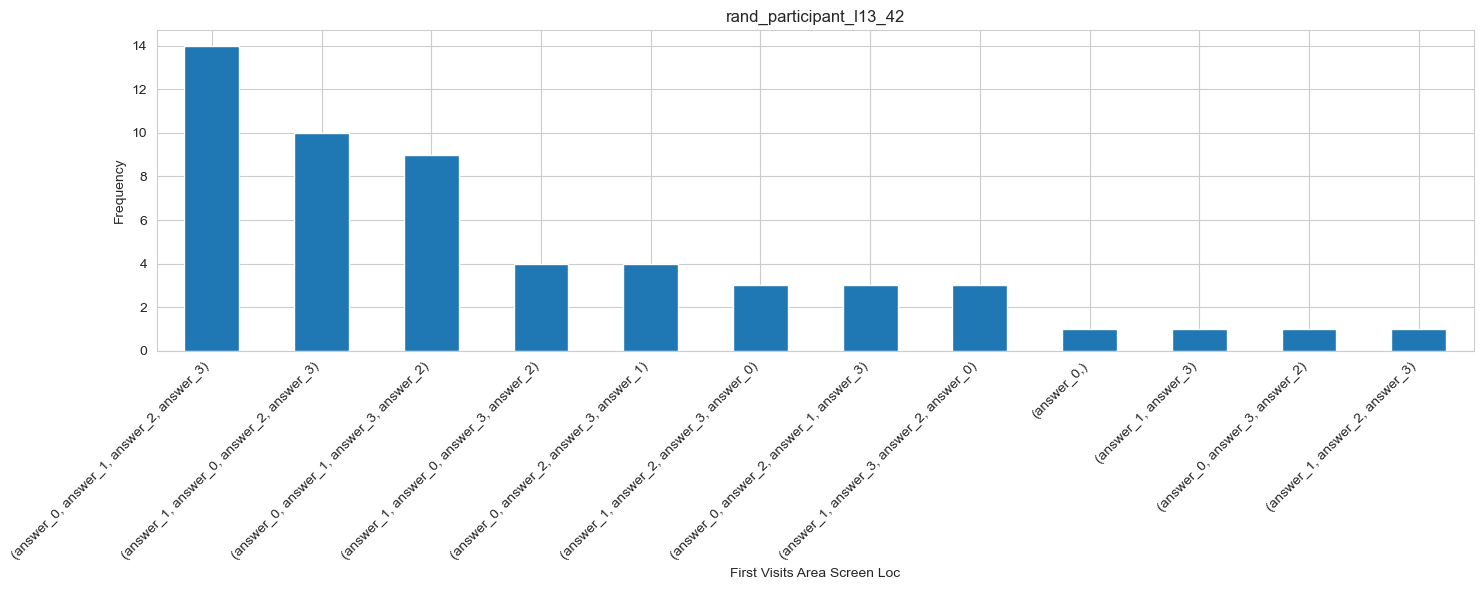

Participant l9_38


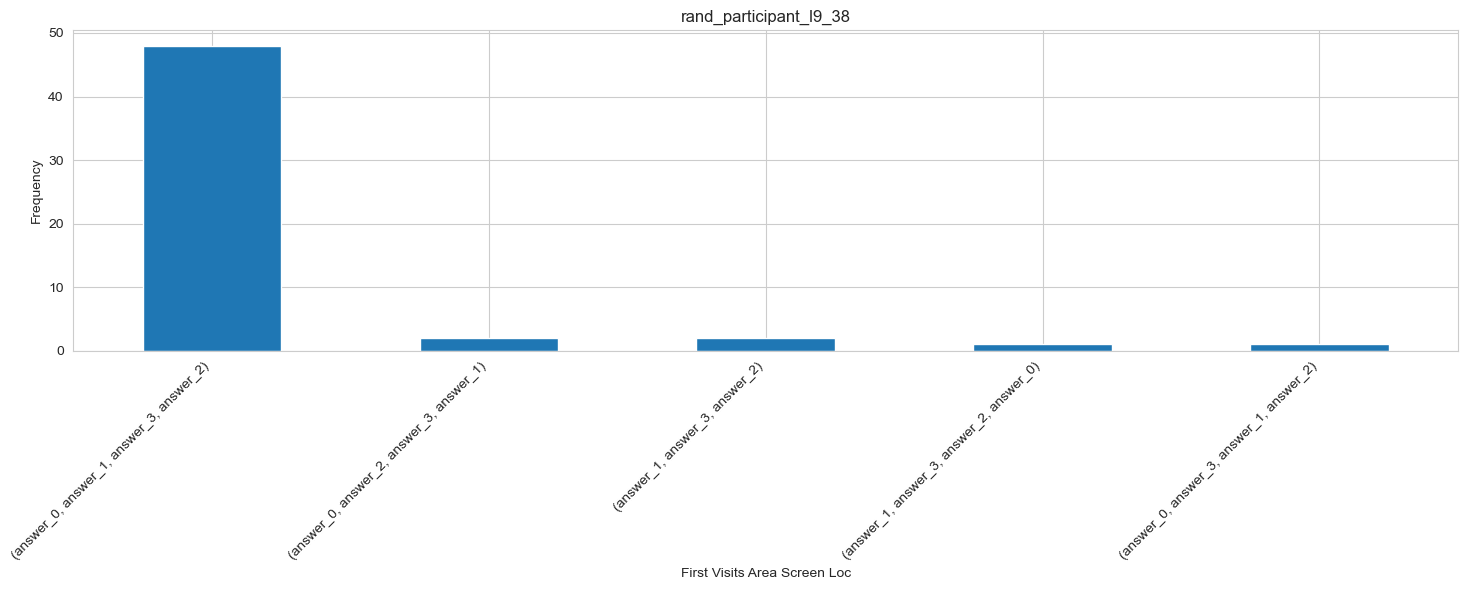

Participant l47_144


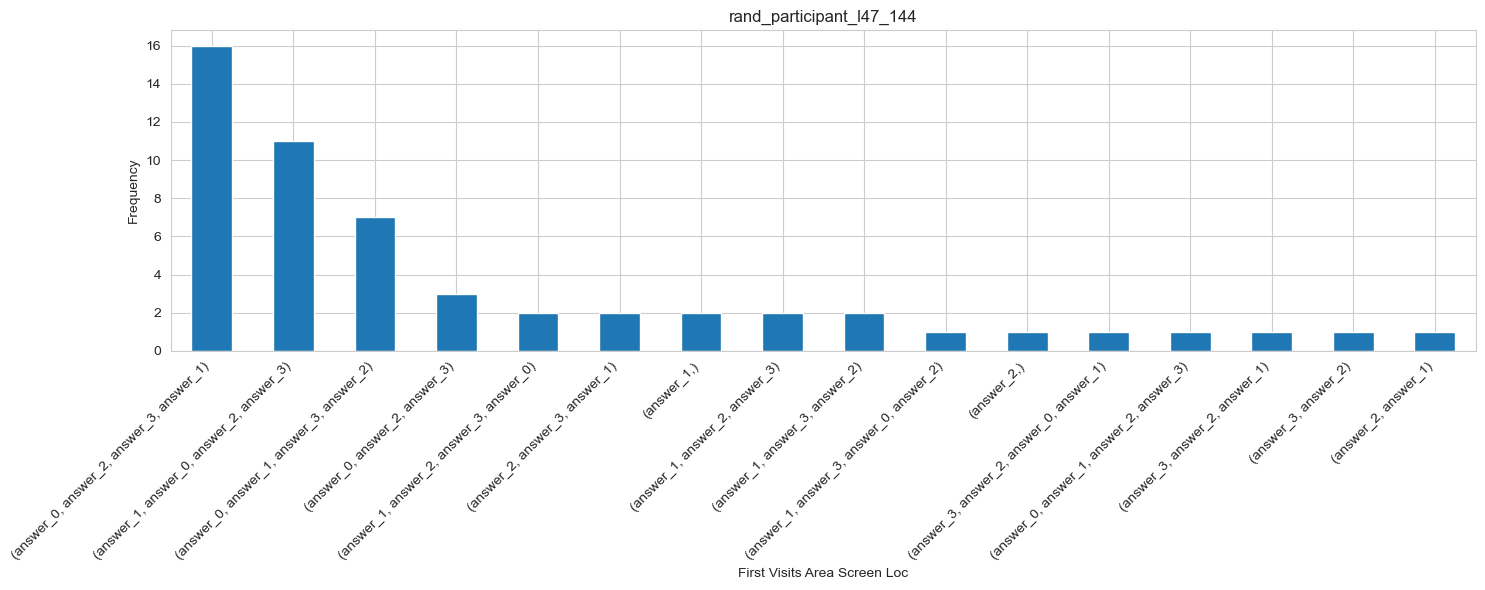

Participant l6_70


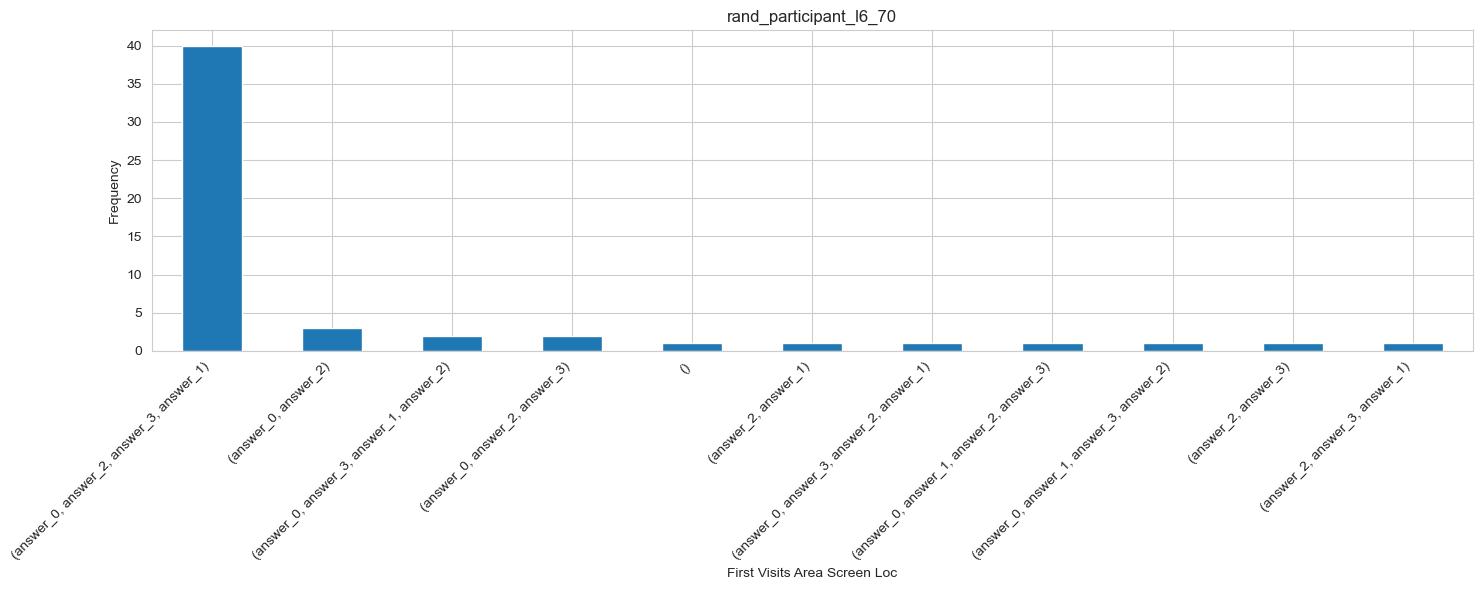

In [444]:
p_ids = df_with_features_h['participant_id'].sample(n=5).to_list()
for p in p_ids:
    print(f'Participant {p}')
    data = df_with_features_h[df_with_features_h['participant_id'] == p]
    for col in ['first_visits_area_screen_loc']:
        df = data[['TRIAL_INDEX', 'participant_id', col]].drop_duplicates()
        plot_freq_hist(df, column=col, top_n=35, h_or_g = 'hunter', ttl = f'rand_participant_{p}')

In [445]:
def proportion_with_dominant_strategy(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',threshold = 0.8):
    counts = df.groupby([id_col, strat_col]).size()
    total = counts.groupby(level=0).sum()
    top = counts.groupby(level=0).max()
    prop = top / total
    is_dominant = prop > threshold
    return is_dominant.mean()

In [446]:
threshold = 0.8
ph = proportion_with_dominant_strategy(df_with_features_h, strat_col = 'first_visits_area_screen_loc',threshold = threshold)
pg = proportion_with_dominant_strategy(df_with_features_g, strat_col = 'first_visits_area_screen_loc',threshold = threshold)

print(f"{ph:.1%} of hunter participants had a dominant strategy (>{threshold*100}% of trials).")
print(f"{pg:.1%} of gatherer participants had a dominant strategy (>{threshold*100}% of trials).")


13.9% of hunter participants had a dominant strategy (>80.0% of trials).
21.7% of gatherer participants had a dominant strategy (>80.0% of trials).


In [456]:
def plot_dominant_strategy_hist(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                            bins = 20, figsize = (6, 4), h_or_g = 'h', save = True):

    counts = df.groupby([id_col, strat_col]).size()
    total = counts.groupby(level=0).sum()
    top   = counts.groupby(level=0).max()
    dominant_prop = top / total

    if isinstance(bins, int):
        bin_edges = np.linspace(0, 1, bins + 1)
    else:
        bin_edges = np.asarray(bins)

    plt.figure(figsize=figsize)
    plt.hist(dominant_prop, bins=bin_edges)
    plt.xlabel('Proportion of trials in dominant strategy')
    plt.ylabel('Number of participants')
    plt.title(f'Distribution of Dominant-Strategy Usage ({h_or_g})')
    ticks = bin_edges
    plt.xticks(ticks, [f"{int(x*100)}%" for x in ticks], rotation=45)
    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dominant_prop_{strat_col}_{h_or_g}.png")
    plt.show()


    return dominant_prop

In [457]:
def plot_dominance_gap(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                        bins = 20, figsize = (12, 5) , h_or_g = 'h', save = True,
                        hist_kwargs = None, scatter_kwargs = None):

    hist_kwargs   = hist_kwargs   or {'edgecolor':'k'}
    scatter_kwargs = scatter_kwargs or {'alpha':0.7}

    counts = df.groupby([id_col, strat_col]).size().unstack(fill_value=0)
    props = counts.div(counts.sum(axis=1), axis=0)

    p1 = props.max(axis=1)
    def second_largest(row):
        vals = row[row>0].nlargest(2)
        return vals.iloc[-1] if len(vals)>1 else 0
    p2 = props.apply(second_largest, axis=1)
    gap = p1 - p2

    result = pd.DataFrame({'p1': p1, 'p2': p2, 'gap': gap})

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].hist(gap, bins=bins, **hist_kwargs)
    axes[0].set_xlabel('Gap (P1 – P2)')
    axes[0].set_ylabel('Number of participants')
    axes[0].set_title(f'Histogram of Dominance Gaps ({h_or_g}) ')

    axes[1].scatter(p2, p1, **scatter_kwargs)
    axes[1].plot([0,1], [0,1], 'r--', label='P1=P2')
    axes[1].set_xlabel('2nd-most common proportion (P2)')
    axes[1].set_ylabel('Most common proportion (P1)')
    axes[1].set_title(f'P2 vs. P1 per Participant ({h_or_g})')
    axes[1].legend()

    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dominance_gap_{strat_col}_{h_or_g}.png")
    plt.show()

    return result

In [458]:
def plot_strategy_count_distribution(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                                    figsize = (6,4), bins = None,  h_or_g = 'h', save = True, **plot_kwargs):

    strat_counts = df.groupby(id_col)[strat_col].nunique()

    plt.figure(figsize=figsize)
    if bins is None:
        max_strat = strat_counts.max()
        bins = np.arange(0.5, max_strat + 1.5, 1.0)
    plt.hist(strat_counts, bins=bins, **plot_kwargs)
    plt.xlabel('Number of distinct strategies used')
    plt.ylabel('Number of participants')
    plt.title(f'Distribution of Strategy Counts ({h_or_g})')
    ticks = np.arange(1, strat_counts.max()+1)
    plt.xticks(ticks)

    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dom_str_counts_{strat_col}_{h_or_g}.png")

    plt.show()

    return strat_counts

In [459]:
def plot_dominant_strategy_counts_above_threshold(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                                                threshold = 0.5, figsize = (8, 4), h_or_g = 'h', save = True, **bar_kwargs):

    counts = df.groupby([id_col, strat_col]).size().unstack(fill_value=0)
    props = counts.div(counts.sum(axis=1), axis=0)
    dominant_prop = props.max(axis=1)
    dominant_strat = props.idxmax(axis=1)
    mask = dominant_prop >= threshold
    filtered = dominant_strat[mask]
    freq = filtered.value_counts()
    freq = freq.sort_values(ascending=False)


    plt.figure(figsize=figsize)
    freq.plot(kind='bar', **bar_kwargs)
    plt.xlabel(strat_col)
    plt.ylabel('Number of participants')
    pct = int(threshold * 100)
    plt.title(f'Dominant Strategies (≥ {pct}% of trials) — Count of Participants ({h_or_g})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/str_above_thresh_{strat_col}_{h_or_g}.png")

    plt.show()

    return freq


In [460]:
def plot_strategies(df, id_col,strat_col, h_or_g = 'h'):
    dominant = plot_dominant_strategy_hist(
        df,
        id_col=id_col,
        strat_col=strat_col,
        bins=20,
        figsize=(8,5),
        h_or_g = h_or_g
    )


    gaps = plot_dominance_gap(
        df,
        id_col=id_col,
        strat_col=strat_col,
        bins=20,
        figsize=(10,4),
        h_or_g = h_or_g
    )

    counts = plot_strategy_count_distribution(
        df,
        id_col=id_col,
        strat_col = strat_col,
        h_or_g = h_or_g
    )

    strategies = plot_dominant_strategy_counts_above_threshold(
        df,
        id_col=id_col,
        strat_col=strat_col,
        threshold=0.5,
        h_or_g = h_or_g
    )


    return dominant, gaps, counts,strategies


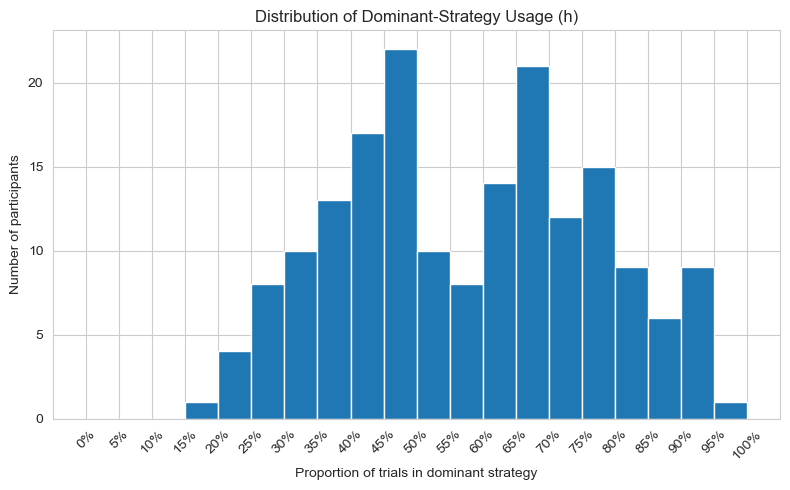

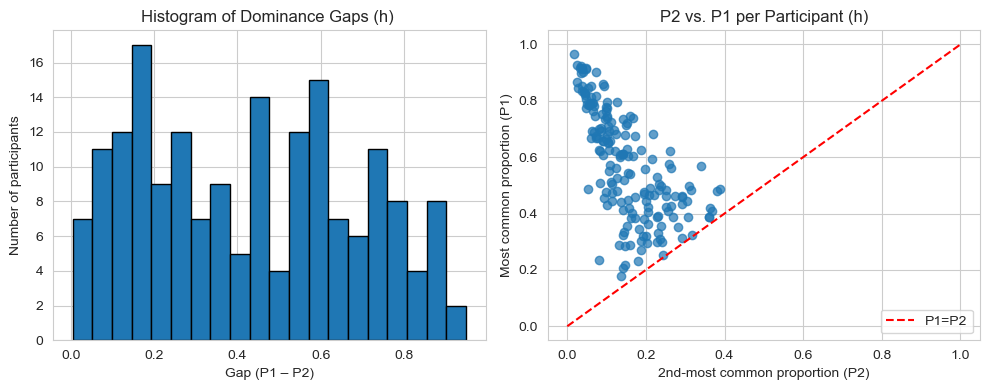

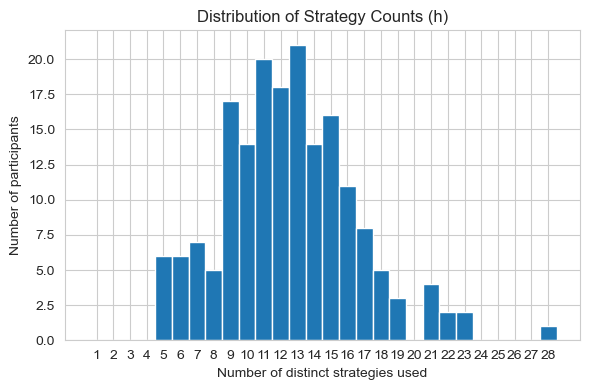

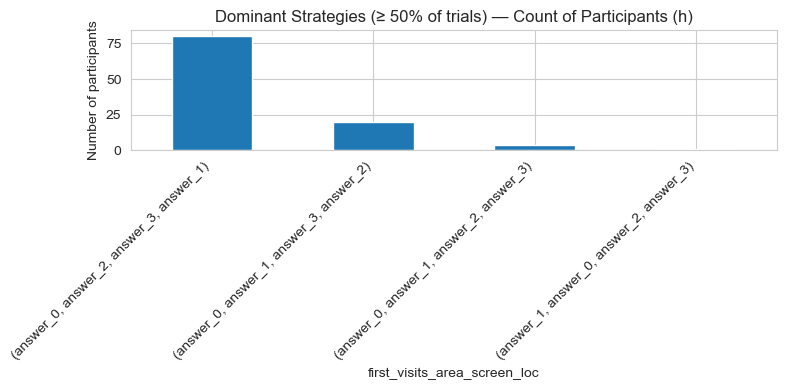

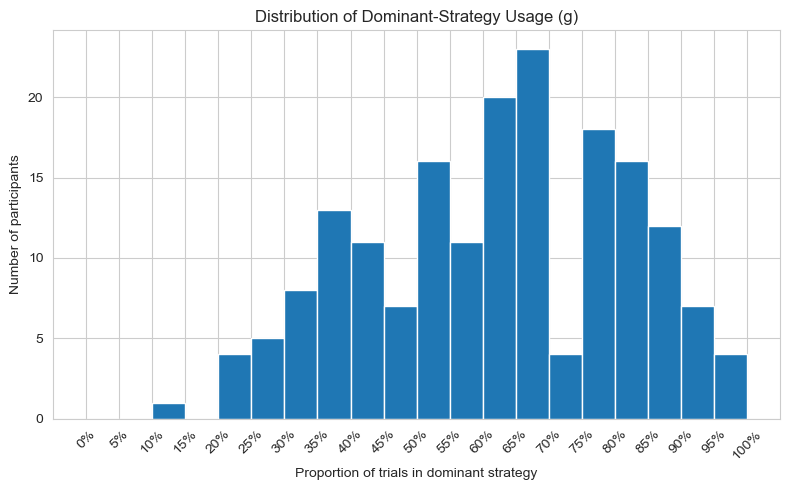

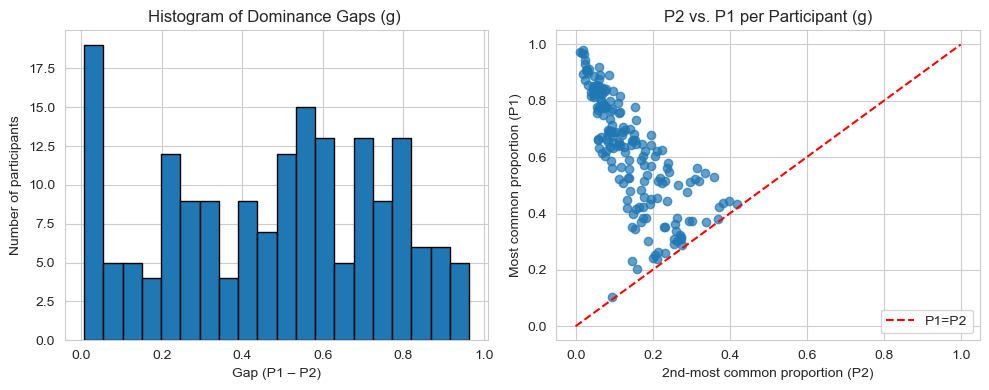

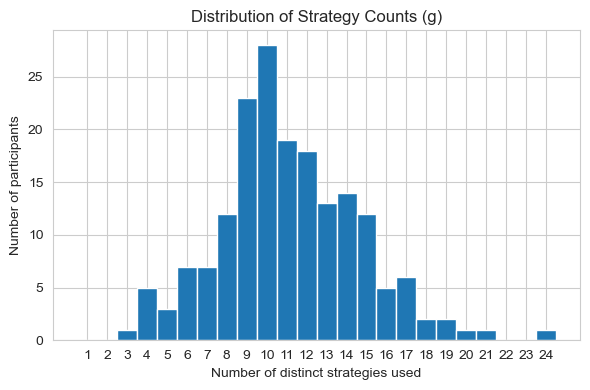

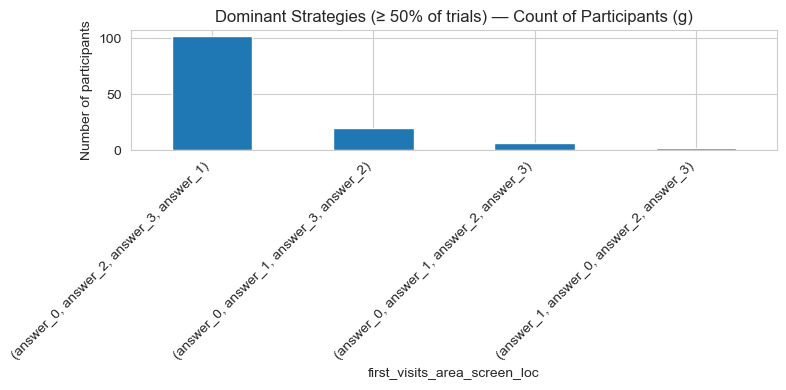

In [461]:
dh, gh, ch, sh = plot_strategies(df_with_features_h, id_col='participant_id',strat_col='first_visits_area_screen_loc', h_or_g='h')
dg, gg, cg, sg = plot_strategies(df_with_features_g, id_col='participant_id',strat_col='first_visits_area_screen_loc', h_or_g='g')


#### Sequences

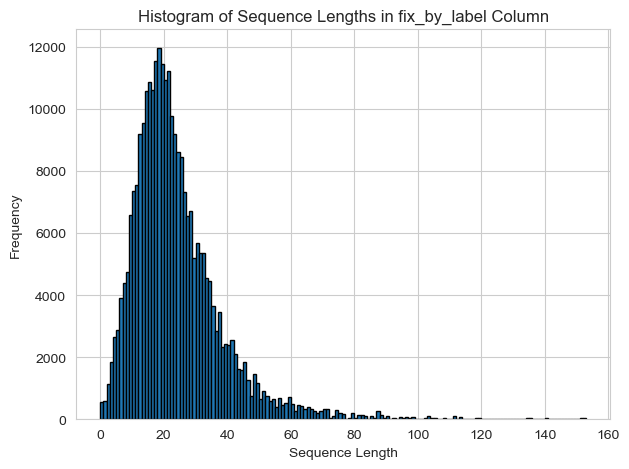

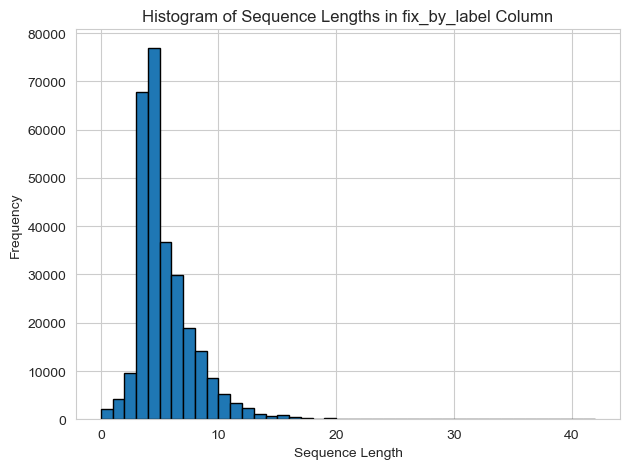

In [470]:
sequence_lengths_full = df_with_features_h['fix_by_label'].apply(len)
sequence_lengths_simpl = df_with_features_h['simpl_fix_by_label'].apply(len)

def plot_seq_length(sequence_lengths, col = None):
    plt.figure()
    plt.hist(sequence_lengths, bins=range(sequence_lengths.min(), sequence_lengths.max() + 2), edgecolor='black')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sequence Lengths in fix_by_label Column')
    plt.tight_layout()
    plt.savefig(f'plots/sequence_freq/{col}')
    plt.show()

plot_seq_length(sequence_lengths_full, 'fix_by_label')
plot_seq_length(sequence_lengths_simpl, 'simpl_fix_by_label')

#### Clock

### Distance measure

In [27]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt
import umap

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from scipy.spatial.distance import squareform

from Bio import pairwise2
import Levenshtein

from sklearn.metrics import silhouette_score

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


#### 1. Self made

In [28]:
def sequence_distance(item1, item2, dist=1):
    m = 0.83

    fix_seq1, fix_dur1, _, _ = item1
    fix_seq2, fix_dur2, _, _ = item2

    fix_seq1, fix_dur1 = list(fix_seq1), list(fix_dur1)
    fix_seq2, fix_dur2 = list(fix_seq2), list(fix_dur2)

    if not fix_seq1:
        fix_seq1 = [0]
        fix_dur1 = [0]
    if not fix_seq2:
        fix_seq2 = [0]
        fix_dur2 = [0]

    alignments = pairwise2.align.globalxx(fix_seq1, fix_seq2,gap_char=['-'])
    best_alignment = alignments[0]
    aln_tokens1 = best_alignment[0]
    aln_tokens2 = best_alignment[1]

    aligned_dur1 = []
    aligned_dur2 = []
    idx1 = 0
    idx2 = 0

    for token_a, token_b in zip(aln_tokens1, aln_tokens2):
        if token_a == "-":
            aligned_dur1.append(0)
        else:
            aligned_dur1.append(fix_dur1[idx1])
            idx1 += 1

        if token_b == "-":
            aligned_dur2.append(0)
        else:
            aligned_dur2.append(fix_dur2[idx2])
            idx2 += 1

    total_distance = 0
    for s1, d1, s2, d2 in zip(aln_tokens1, aligned_dur1, aln_tokens2, aligned_dur2):
        if s1 == s2:
            total_distance += abs(d1 - d2) * (m**dist)
        else:
            total_distance += (d1 + d2) * (m**dist)

    return total_distance

#### 2. Levenshtein

In [29]:
def levenshtein_sequence_distance(item1, item2):
    return Levenshtein.distance(item1[0], item2[0])

#### 3. R wrapper

In [30]:
%load_ext rpy2.ipython

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [31]:
%%R
# rpy2.library("devtools")
# rpy2.install_github("tmalsburg/scanpath/scanpath", dependencies=TRUE)
# rpy2.library(scanpath)

library(devtools)
install_github("tmalsburg/scanpath/scanpath", dependencies=TRUE)
library(scanpath)

R[write to console]: Loading required package: usethis

R[write to console]: Using GitHub PAT from the git credential store.

R[write to console]: Skipping install of 'scanpath' from a github remote, the SHA1 (6984b604) has not changed since last install.
  Use `force = TRUE` to force installation



In [32]:
import rpy2.robjects as ro

def scasim_py(
    df: pd.DataFrame,
    formula: str,
    center_x: int = 1280,
    center_y: int = 720,
    viewing_distance: int = 77,
    unit_size: float = 1 / 60,
    #normalize: bool | str = False,
    normalize: bool = False,
) -> np.ndarray:
    ro.pandas2ri.activate()
    scanpath = ro.packages.importr(name="scanpath")

    with (ro.default_converter + ro.pandas2ri.converter).context():
        r_dataframe = ro.conversion.get_conversion().py2rpy(df)

    return scanpath.scasim(
        data=r_dataframe,
        formula=ro.Formula(formula),
        center_x=center_x,
        center_y=center_y,
        viewing_distance=viewing_distance,
        unit_size=unit_size,
        normalize=normalize,
    )


def alignment_plot_py(
    sp1: pd.DataFrame,
    sp2: pd.DataFrame,
    diff_by: str = "synthesized",
    center_x: int = 1280,
    center_y: int = 720,
    viewing_distance: int = 77,
    unit_size: float = 1 / 60,
):
    ro.pandas2ri.activate()
    scanpath = ro.packages.importr(name="scanpath")
    ggplot = ro.packages.importr("ggplot2")

    with (ro.default_converter + ro.pandas2ri.converter).context():
        sp_r_df_1 = ro.conversion.get_conversion().py2rpy(sp1)
        sp_r_df_2 = ro.conversion.get_conversion().py2rpy(sp2)

    alignment = scanpath.rscasim(
        sp_r_df_1,
        sp_r_df_2,
        formula=ro.Formula(
            f"CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | {diff_by}"
        ),
        center_x=center_x,
        center_y=center_y,
        viewing_distance=viewing_distance,
        unit_size=unit_size,
    )

    alignment_plot = scanpath.plot_alignment(
        sp_r_df_1,
        sp_r_df_2,
        ro.conversion.get_conversion().py2rpy(alignment),
        ro.Formula(f"CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | {diff_by}"),
        10,
        10,
    )

    # save the plot
    ggplot.ggsave(
        ro.conversion.get_conversion().py2rpy(alignment_plot), "alignment_plot.png"
    )

In [33]:
def scasim_sequence_distance(item1, item2):

    seq1, dur1, x1, y1 = item1
    seq2, dur2, x2, y2 = item2

    if not dur1:
        dur1, x1, y1 = [0], [0], [0]
    if not dur2:
        dur2, x2, y2 = [0], [0], [0]

    df1 = pd.DataFrame({
        "CURRENT_FIX_DURATION": dur1,
        "CURRENT_FIX_X":         x1,
        "CURRENT_FIX_Y":         y1,
        "trial":                 1
    })
    df2 = pd.DataFrame({
        "CURRENT_FIX_DURATION": dur2,
        "CURRENT_FIX_X":         x2,
        "CURRENT_FIX_Y":         y2,
        "trial":                 2
    })
    df_combined = pd.concat([df1, df2], ignore_index=True)

    dist_mat = scasim_py(
        df=df_combined,
        formula="CURRENT_FIX_DURATION ~ CURRENT_FIX_X + CURRENT_FIX_Y | trial"
    )
    dist_mat = np.asarray(dist_mat)
    return float(dist_mat[0, 1])


#### 2D Levenshtein

In [326]:
def levenshtein_2D_eucl(item1, item2, ins_cost=1.0, del_cost=1.0):
    loc_map = {
        "answer_0": 0,
        "answer_1": 1,
        "answer_2": 2,
        "answer_3": 3,
        "question": 4
    }
    label_map = {
        "answer_A": 0,
        "answer_B": 1,
        "answer_C": 2,
        "answer_D": 3,
        "question": 4
    }


    loc_seq1, label_seq1 = item1[0], item1[4]
    loc_seq2, label_seq2 = item2[0], item2[4]

    def to_vec(loc,label):
        return np.array([loc_map[loc],
                         label_map[label]], dtype=float)

    pts1 = [to_vec(l,lbl) for l,lbl in zip(loc_seq1, label_seq1)]
    pts2 = [to_vec(l,lbl) for l,lbl in zip(loc_seq2, label_seq2)]

    n, m = len(pts1), len(pts2)
    D = np.zeros((n+1, m+1), dtype=float)
    for i in range(1, n+1): D[i,0] = i * del_cost
    for j in range(1, m+1): D[0,j] = j * ins_cost

    for i in range(1, n+1):
        for j in range(1, m+1):
            sub = np.linalg.norm(pts1[i-1] - pts2[j-1])
            D[i,j] = min(
                D[i-1,j]   + del_cost,  # delete
                D[i,j-1]   + ins_cost,  # insert
                D[i-1,j-1] + sub        # substitute
            )
    return D[n,m]


In [327]:
def levenshtein_2D_mismatch(item1, item2):
    loc_map = {
        "answer_0": 0,
        "answer_1": 1,
        "answer_2": 2,
        "answer_3": 3,
        "question": 4
    }
    label_map = {
        "answer_A": 0,
        "answer_B": 1,
        "answer_C": 2,
        "answer_D": 3,
        "question": 4
    }

    loc_seq1, label_seq1 = item1[0], item1[4]
    loc_seq2, label_seq2 = item2[0], item2[4]

    def to_vec(loc,label):
        return np.array([loc_map[loc], label_map[label]], dtype=float)

    pts1 = [to_vec(l,lbl) for l,lbl in zip(loc_seq1, label_seq1)]
    pts2 = [to_vec(l,lbl) for l,lbl in zip(loc_seq2, label_seq2)]

    n, m = len(pts1), len(pts2)
    D = np.zeros((n+1, m+1), dtype=float)

    for i in range(1, n+1):
        D[i,0] = i
    for j in range(1, m+1):
        D[0,j] = j

    for i in range(1, n+1):
        x1, y1 = pts1[i-1]
        for j in range(1, m+1):
            x2, y2 = pts2[j-1]

            sub_cost = (x1 != x2) + (y1 != y2)

            D[i,j] = min(
                D[i-1,j]   + 1,   # delete
                D[i,j-1]   + 1,   # insert
                D[i-1,j-1] + sub_cost    # substitute
            )

    return D[n,m]


### Clusterers

In [208]:
def seq_cluster_kmeans(df, seq_col, dur_col, x_col, y_col, seq_col2, distance_func=sequence_distance,
                       n_clusters=5, mds_components=30):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]), axis=1).tolist()


    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    mds = MDS(n_components=mds_components, dissimilarity='precomputed')
    mds_embedding = mds.fit_transform(distance_matrix)

    kmeans_clusterer = KMeans(n_clusters=n_clusters)
    labels = kmeans_clusterer.fit_predict(mds_embedding)

    return distance_matrix, labels

In [209]:
def seq_cluster_agglomerative(df, seq_col, dur_col, x_col, y_col, seq_col2,
                              distance_func=sequence_distance, n_clusters=5, linkage = 'average'):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    clusterer = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)
    return distance_matrix, labels


In [241]:
def seq_cluster_dbscan(df, seq_col, dur_col, x_col, y_col, seq_col2,
                       distance_func=sequence_distance, eps=0.99, min_samples=2):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

In [242]:
def seq_cluster_hdbscan(df, seq_col, dur_col, x_col, y_col, seq_col2,
                        distance_func=sequence_distance, min_cluster_size=2, min_samples = 5,
                        cluster_selection_method='eom',  cluster_selection_epsilon=None):
    items = df.apply(lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]), axis=1).tolist()

    n = len(items)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    hdb_args = {
        'metric': 'precomputed',
        'min_cluster_size': min_cluster_size,
        'min_samples': min_samples,
        'cluster_selection_method': cluster_selection_method,
        'algorithm': 'best'
    }

    if cluster_selection_epsilon is not None:
        eps = float(cluster_selection_epsilon)
        if eps >= 0.0:
            hdb_args['cluster_selection_epsilon'] = eps


    clusterer = hdbscan.HDBSCAN(**hdb_args)
    labels = clusterer.fit_predict(distance_matrix)

    return distance_matrix, labels

### Clustering Visualization

In [38]:
def plot_custom_dendrogram(distance_matrix, subset, tid, seq_col):
    linkage_matrix = linkage(distance_matrix, method='average')
    custom_labels = [", ".join(map(str, seq)) for seq in subset[seq_col]]

    plt.figure(figsize=(12, 6))
    plt.title(f"Dendrogram for text_id: {tid}")
    dendrogram(linkage_matrix, labels=custom_labels,
               leaf_rotation=90,
               leaf_font_size=10)
    plt.xlabel(f"Fixation Sequences ({seq_col}])")
    plt.ylabel("Distance")
    plt.show()

In [39]:
def reordered_heatmap(condensed_distance, distance_matrix, tid):
    linkage_matrix = linkage(condensed_distance, method='average')
    leaf_order = leaves_list(linkage_matrix)
    reordered_matrix = distance_matrix[leaf_order][:, leaf_order]

    plt.figure(figsize=(8, 6))
    plt.title(f"Reordered Distance Matrix for text_id: {tid}")
    im = plt.imshow(reordered_matrix, cmap='viridis', interpolation='nearest')
    plt.xlabel("Reordered Index")
    plt.ylabel("Reordered Index")
    plt.colorbar(im)
    plt.show()

In [40]:
def umap_plot(distance_matrix, labels, tid, n_neighbors = 5, min_dist = 0.1, random_state = 42):
    umap_model = umap.UMAP(
        n_components=2,
        metric='precomputed',
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    embedding = umap_model.fit_transform(distance_matrix)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1],
                c=labels, cmap='plasma', s=15, edgecolor='k', linewidth=0.2)
    plt.title(f"UMAP Projection for text_id: {tid}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()

    return embedding

In [41]:
def mds_plot_from_distances(distance_matrix, labels, tid, n_components = 2, random_state = 42):
    mds = MDS(
        n_components=n_components,
        dissimilarity='precomputed',
        random_state=random_state
    )
    embedding = mds.fit_transform(distance_matrix)

    plt.figure(figsize=(8, 6))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1] if n_components >= 2 else [0]*len(embedding),
        c=labels,
        cmap='plasma',
        s=15,
        edgecolor='k',
        linewidth=0.2
    )
    plt.title(f"MDS Projection for text_id: {tid}")
    plt.xlabel("MDS dim 1")
    plt.ylabel(f"MDS dim 2{'+' if n_components>2 else ''}")
    plt.tight_layout()
    plt.show()


### The Clustering Function

In [330]:
def cluster_by_text(df, tid, seq_col, dur_col, x_col, y_col, seq_col2, dist_func, clusterer,
                    mds_components = 2, umap_n_neighbors = 15, umap_min_dist = 0.1):
    if tid:
        subset = df[df['text_id'] == tid]
        print(f"\n=== Processing text_id: {tid} ===")
    else:
        subset = df
        print(f"\n=== Processing the whole given dataframe ===")


    func, func_kwargs = clusterer
    distance_matrix, labels = func(subset, seq_col, dur_col, x_col, y_col, seq_col2,
                                            distance_func=dist_func, **func_kwargs)


    condensed = squareform(distance_matrix)

    mds_plot_from_distances(
        distance_matrix=distance_matrix,
        labels=labels,
        tid=tid,
        n_components=mds_components
    )

    umap_emb = umap_plot(
        distance_matrix=distance_matrix,
        labels=labels,
        tid=tid,
        n_neighbors=umap_n_neighbors,
        min_dist = umap_min_dist,
    )

    reordered_heatmap(condensed, distance_matrix, tid)
    #plot_custom_dendrogram(condensed, subset, tid, seq_col)

    out = subset.reset_index(drop=True)[['participant_id', 'text_id', seq_col]].copy()
    out['cluster_label'] = labels
    out['UMAP1'] = umap_emb[:, 0]
    out['UMAP2'] = umap_emb[:, 1]
    return out, distance_matrix

### Finetunings

In [280]:
ids = df_with_features_h['text_id'].sample(n=250).to_list()

seq_c = 'simpl_fix_by_loc'
dur_c = 'simpl_fix_duration'
x_c   = 'simpl_fix_x'
y_c   = 'simpl_fix_y'
seq_c2  = 'simpl_fix_by_label'

h_r = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', seq_c, dur_c, x_c, y_c, seq_c2]].drop_duplicates()
subset = h_r[h_r['text_id'].isin(ids)]

In [258]:
def grid_search_kmeans(df, seq_col, dur_col,x_col,y_col, seq_col2,
                        distance_func, n_clusters_list, mds_components_list):
    records = []
    for k in n_clusters_list:
        for mds_c in mds_components_list:
            dist_mat, labels = seq_cluster_kmeans(
                df, seq_col, dur_col, x_col, y_col, seq_col2,
                distance_func=distance_func,
                n_clusters=k,
                mds_components=mds_c)

            if len(set(labels)) > 1 and len(set(labels)) < len(labels):
                score = silhouette_score(dist_mat, labels, metric='precomputed')
            else:
                score = -1.0

            records.append({
                'n_clusters':    k,
                'mds_components': mds_c,
                'silhouette':    score })

    results_df = pd.DataFrame.from_records(records)
    best_row = results_df.loc[results_df['silhouette'].idxmax()]
    best_params = {
        'n_clusters':     int(best_row['n_clusters']),
        'mds_components': int(best_row['mds_components']),
    }

    return results_df, best_params

In [266]:
def grid_search_agglomerative(df, seq_col, dur_col, x_col, y_col, seq_col2,
                                distance_func, n_clusters_list, linkage_list = ["average"]):
    records = []
    for linkage in linkage_list:
        for k in n_clusters_list:
            items = df.apply(
                lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]),
                axis=1
            ).tolist()
            n = len(items)
            dist_mat = np.zeros((n, n), dtype=float)
            for i in range(n):
                for j in range(i, n):
                    d = distance_func(items[i], items[j])
                    dist_mat[i, j] = d
                    dist_mat[j, i] = d

            if linkage == "ward":
                from sklearn.cluster import AgglomerativeClustering
                clusterer = AgglomerativeClustering(
                    linkage="ward",
                    n_clusters=k)
                labels = clusterer.fit_predict(dist_mat)
            else:
                from sklearn.cluster import AgglomerativeClustering
                clusterer = AgglomerativeClustering(
                    linkage=linkage,
                    n_clusters=k,
                    metric="precomputed")

                labels = clusterer.fit_predict(dist_mat)

            if len(set(labels)) > 1 and len(set(labels)) < n:
                score = silhouette_score(dist_mat, labels, metric="precomputed")
            else:
                score = -1.0

            records.append({
                "linkage":      linkage,
                "n_clusters":   k,
                "silhouette":   score
            })

    results_df = pd.DataFrame.from_records(records)
    best_row = results_df.loc[results_df["silhouette"].idxmax()]
    best_params = {
        "linkage":    best_row["linkage"],
        "n_clusters": int(best_row["n_clusters"]),
    }
    return results_df, best_params

In [260]:
def grid_search_dbscan( df, seq_col, dur_col, x_col, y_col, seq_col2,
                        distance_func, eps_list, min_samples_list):

    items = df.apply(
        lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]),
        axis=1).tolist()

    n = len(items)
    dist_mat = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            dist_mat[i, j] = d
            dist_mat[j, i] = d

    records = []
    for eps in eps_list:
        for ms in min_samples_list:
            clusterer = DBSCAN(
                eps=eps,
                min_samples=ms,
                metric='precomputed'
            )
            labels = clusterer.fit_predict(dist_mat)

            unique_labels = set(labels)
            if len(unique_labels - {-1}) > 1:
                score = silhouette_score(dist_mat, labels, metric='precomputed')
            else:
                score = -1.0

            records.append({
                'eps':          eps,
                'min_samples':  ms,
                'silhouette':   score
            })

    results_df = pd.DataFrame.from_records(records)
    best_row = results_df.loc[results_df['silhouette'].idxmax()]
    best_params = {
        'eps':         float(best_row['eps']),
        'min_samples': int(best_row['min_samples']),
    }

    return results_df, best_params

In [261]:
def grid_search_hdbscan(df, seq_col, dur_col, x_col, y_col, seq_col2,
                        dist_func, min_cluster_sizes, min_samples_list, cluster_selection_methods, cluster_selection_epsilons,
):

    items = df.apply(
        lambda row: (row[seq_col], row[dur_col], row[x_col], row[y_col], row[seq_col2]),
        axis=1
    ).tolist()
    n = len(items)
    dist_mat = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            d = dist_func(items[i], items[j])
            dist_mat[i, j] = d
            dist_mat[j, i] = d

    records = []
    for mcs in min_cluster_sizes:
        for ms in min_samples_list:
            for csm in cluster_selection_methods:
                for cse in cluster_selection_epsilons:
                    hargs = {
                        "metric": "precomputed",
                        "min_cluster_size": mcs,
                        "min_samples": ms,
                        "cluster_selection_method": csm,
                    }
                    if cse is not None:
                        hargs["cluster_selection_epsilon"] = cse

                    cl = hdbscan.HDBSCAN(**hargs)
                    labels = cl.fit_predict(dist_mat)

                    if len(set(labels)) > 1 and len(set(labels)) < n:
                        score = silhouette_score(dist_mat, labels, metric="precomputed")
                    else:
                        score = -1.0

                    records.append({
                        "min_cluster_size":         mcs,
                        "min_samples":              ms,
                        "cluster_selection_method": csm,
                        "cluster_selection_epsilon": cse,
                        "silhouette":               score
                    })

    results_df = pd.DataFrame.from_records(records)
    best_row = results_df.loc[results_df["silhouette"].idxmax()]
    best_params = {
        "min_cluster_size":          int(best_row["min_cluster_size"]),
        "min_samples":               int(best_row["min_samples"]),
        "cluster_selection_method":  best_row["cluster_selection_method"],
        "cluster_selection_epsilon": best_row["cluster_selection_epsilon"],
    }
    return results_df, best_params


In [281]:
from itertools import combinations
from sklearn.metrics import adjusted_rand_score

def grid_search_all(df,
                    seq_col, dur_col, x_col, y_col, seq_col2,
                    distance_func,
                    spaces):

    top_params = {}

    GS = {
      'kmeans':        grid_search_kmeans,
      'agglomerative': grid_search_agglomerative,
      'dbscan':        grid_search_dbscan,
      'hdbscan':       grid_search_hdbscan,
    }

    for name, gs_fn in GS.items():
        results_df, _ = gs_fn(
            df, seq_col, dur_col, x_col, y_col, seq_col2,
            distance_func,
            **spaces[name]
        )
        top3 = results_df.nlargest(3, 'silhouette')
        top_params[name] = top3.drop(columns=['silhouette']) \
                                 .to_dict(orient='records')

    return top_params



def evaluate_clusterings(df,
                        seq_col, dur_col, x_col, y_col, seq_col2,
                        distance_func,
                        top_params):

    CL = {
      'kmeans':        seq_cluster_kmeans,
      'agglomerative': seq_cluster_agglomerative,
      'dbscan':        seq_cluster_dbscan,
      'hdbscan':       seq_cluster_hdbscan,
    }

    items = df.apply(lambda r: (r[seq_col], r[dur_col], r[x_col], r[y_col], r[seq_col2]),
                     axis=1).tolist()
    n = len(items)
    dist_mat = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            d = distance_func(items[i], items[j])
            dist_mat[i,j] = d
            dist_mat[j,i] = d

    labels_dict = {}
    sil_scores  = {}
    for name, params_list in top_params.items():
        for idx, params in enumerate(params_list, start=1):
            func = CL[name]
            _, labels = func(
                df, seq_col, dur_col, x_col, y_col, seq_col2,
                distance_func=distance_func,
                **params
            )
            key = f"{name}_{idx}"
            labels_dict[key] = labels
            unique_labels = set(labels)
            if 1 < len(unique_labels) < len(labels):
                sil_scores[key] = silhouette_score(dist_mat, labels,
                                                   metric='precomputed')
            else:
                sil_scores[key] = float('nan')

    ari_records = []
    for (k1,l1),(k2,l2) in combinations(labels_dict.items(), 2):
        ari_records.append({
            'clust_A': k1,
            'clust_B': k2,
            'ARI':     adjusted_rand_score(l1, l2)
        })
    ari_df = pd.DataFrame.from_records(ari_records)

    sil_df = pd.DataFrame([
        {'clustering': k, 'silhouette': v}
        for k,v in sil_scores.items()
    ])

    return ari_df, sil_df


spaces = {
  'kmeans':        {'n_clusters_list': [4,5,8,10], 'mds_components_list': [2,5,10]},
  'agglomerative': {'n_clusters_list': [2,4,5,8],   'linkage_list': ['average','single','complete']},
  'dbscan':        {'eps_list': [0.3, 0.5,0.7,0.9],       'min_samples_list': [2,5,10]},
  'hdbscan':       {
      'min_cluster_sizes': [20,35],
      'min_samples_list':  [5,10],
      'cluster_selection_methods': ['eom','leaf'],
      'cluster_selection_epsilons': [None,0.1],
  },
}



In [282]:
# top_params = grid_search_all(
#     df=subset,
#     seq_col=seq_c,
#     dur_col=dur_c,
#     x_col=x_c,
#     y_col=y_c,
#     seq_col2= seq_c2,
#     distance_func=levenshtein_2D_eucl,
#     spaces=spaces
# )
#
# ari, sil = evaluate_clusterings(
#     df=subset,
#     seq_col=seq_c,
#     dur_col=dur_c,
#     x_col=x_c,
#     y_col=y_c,
#     seq_col2= seq_c2,
#     distance_func=levenshtein_2D_eucl,
#     top_params=top_params
# )


,clust_A,clust_B,ARI
0,kmeans_1,kmeans_2,0.550869
1,kmeans_1,kmeans_3,0.449636
2,kmeans_1,agglomerative_1,-0.000091
3,kmeans_1,agglomerative_2,-0.000091
4,kmeans_1,agglomerative_3,0.000127
...,...,...,...
61,dbscan_3,hdbscan_2,-0.101716
62,dbscan_3,hdbscan_3,-0.052226
63,hdbscan_1,hdbscan_2,1.000000
64,hdbscan_1,hdbscan_3,0.544481


In [345]:
#sil

,clustering,silhouette
0,kmeans_1,0.148760
1,kmeans_2,0.165317
2,kmeans_3,0.107042
3,agglomerative_1,0.701254
4,agglomerative_2,0.701254
5,agglomerative_3,0.624472
6,dbscan_1,0.033419
7,dbscan_2,0.033419
8,dbscan_3,0.033419
9,hdbscan_1,-0.000954


In [289]:
# top_df = pd.DataFrame(top_params)
# top_df.to_csv('top.csv')

In [346]:
cl = (seq_cluster_hdbscan, {'min_cluster_size': 35, 'min_samples': 5})
cl2 = (seq_cluster_kmeans, {'n_clusters': 5, 'mds_components': 5})
cl3 = (seq_cluster_agglomerative, {'linkage': 'single', 'n_clusters': 4})

### Runs

In [ ]:
def get_random_text_id(df):
    return df['text_id'].sample(n=1).iloc[0]

knn = (seq_cluster_kmeans, {'n_clusters':5})
aggl = (seq_cluster_agglomerative, {'n_clusters':5})
dbsan = (seq_cluster_dbscan, {'eps':0.7, 'min_samples':2})
hdbs = (seq_cluster_hdbscan, {'min_cluster_size':20, 'min_samples': 10})


=== Processing the whole given dataframe ===


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


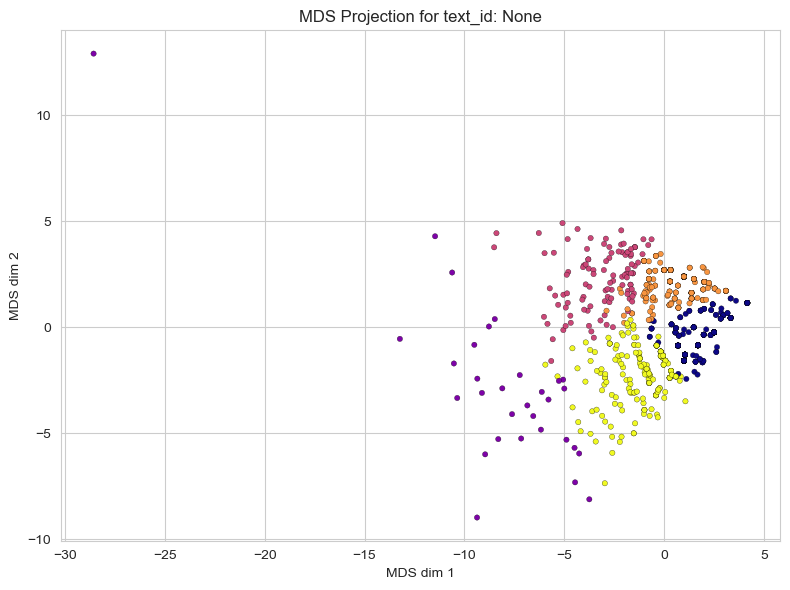

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


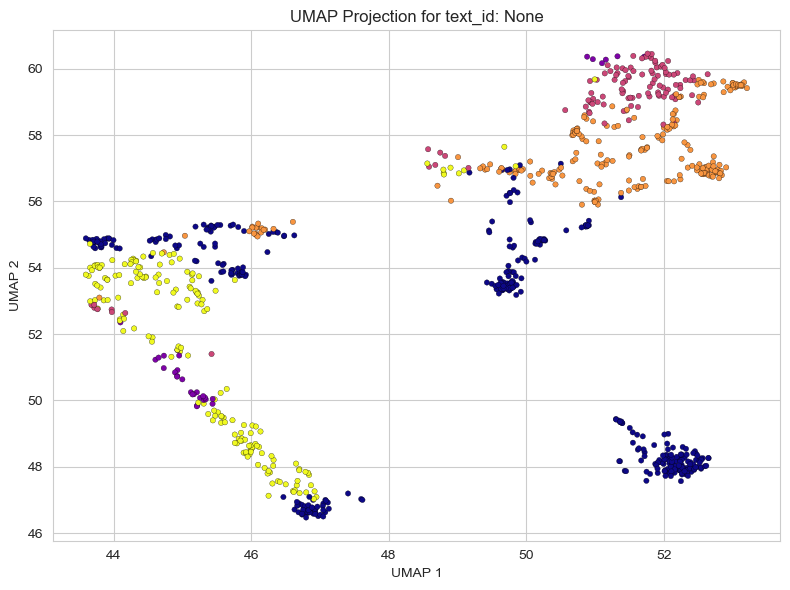

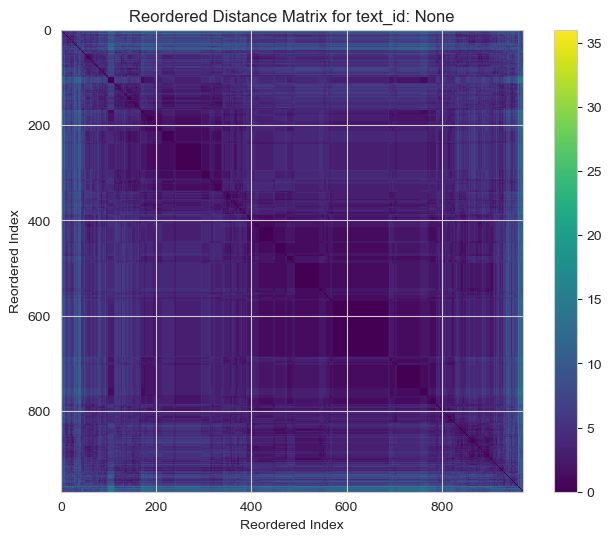

In [375]:
run_ids = df_with_features_h['text_id'].sample(n=100).to_list()

#run_seq_c = 'simpl_fix_by_loc'
run_seq_c = 'clock_loc'
run_dur_c = 'simpl_fix_duration'
run_x_c   = 'simpl_fix_x'
run_y_c   = 'simpl_fix_y'
run_seq_c2  = 'simpl_fix_by_label'

run_h_r = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', run_seq_c, run_dur_c, run_x_c, run_y_c, run_seq_c2]].drop_duplicates()

out, mat = cluster_by_text(run_h_r[run_h_r['text_id'].isin(run_ids)],
                None,
                run_seq_c, run_dur_c,
                run_x_c, run_y_c, run_seq_c2,
                dist_func=levenshtein_sequence_distance,
                clusterer=cl2,
                umap_n_neighbors = 15,
                umap_min_dist = 0.1
                )


In [350]:
sil_pre = silhouette_score(mat, out['cluster_label'], metric='precomputed')
print(f'Silhouette (precomputed): {sil_pre:.3f}')

Silhouette (precomputed): 0.621


In [50]:
#   print frequencies of first 5 elements in the sequence - beginning, end, loc, label.
#   make R wrapper work

#   levenshtein distance
#   scan match (similar to scasim)
#   try to define distances?


In [ ]:
# Need to 2D levenshtein the sequences!
# clockwise, counterclockwise, across - no q
# No "pure" strategy - shortest text to longest? Something else?